# Intruduction

The purpose of this notebook is to see if we can select a subset of the Barents Sea that has a heat or salt anomaly that we can later use for WMT or to look specifically at regions of the ocean with the most extreme changes. The goal of this will be to create a mask of these terms which we can use for the rest.

We could even use just temperature and salt anomalies...

Using the total heat content (J) and the total freshwater content (m), and we can also look at the sea ice, perhaps we can ID a region that has been changing the most in the Barents Sea.

# import packages and files

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import xarray as xr
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
%run /home/mmurakami/crios_backups/an_helper_functions/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [3]:
# load the timesteps
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

# ocean and ice
AB_gT=0
AB_gS=0

allyears = np.arange(2003,2018,1)
dterm = 19                 # set a terminal depth for freshwater and heat calculations

In [4]:
# load the existing mask of the Barents Sea -- this is what we will work from 
whole = True
if not whole:
    iB = 6    # example read from BarentsSea
    
# mymsk below defines as all Arctic down to Fram Strait and BSO but not GINs Seas
mymsk = mskBasin.copy()
mask = ~np.isnan(mymsk)

# Create a boolean mask for elements that are 6 or less
# mask = mymsk <7
# if whole:
#     mask = (mymsk < 5) | (mymsk==6) 
# else:
mask = mymsk == 6

# Set elements that are greater than 6 to np.nan
mymsk[mask] = 1
mymsk[~mask] = np.nan

test = get_aste_tracer(mymsk,nfx,nfy)[0]
# test[:,:270] = np.nan
mymsk = test

mymsk = aste_tracer2compact(mymsk,nfx,nfy)[0]

# Get the number of points where mskBasin is 6 or less
npoints = np.count_nonzero(mymsk)  # Count the number of True values in the mask
print(npoints)

364500


In [5]:
# plt.pcolormesh(get_aste_tracer(mymsk,nfx,nfy)[0])

# load the terms for vertically integrated heat and FW content, SIarea

In [6]:
# create empty arrays of the shape of the time values to store these

# we want vertically-integrated heat content: shape times,month,ny,nx
heat_content = np.full((len(allyears),12,ny,nx),np.nan)
fw_content = np.full((len(allyears),12,ny,nx),np.nan)

In [7]:
si_area_all = np.full((len(allyears),12,ny,nx),np.nan)

In [8]:
# loop through the years to create the timeseries
# alldatetimes = np.array([])
# FW_times = np.array([])
# Heat_times = np.array([])  # this does not make sense as variable name

iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ##########################################################################################
    # get the volume values

    # for mass tendency (m^3/s) - time is not yet included in this block
    file_name = 'budg2d_snap_set1'
    
    # assuming all files are structured the same
    meta_budg2d_snap_set1 = parsemeta(dirIn + file_name + "." + tsstr[0]+ ".meta")
    # try to read this with rec
    fldlist = np.array(meta_budg2d_snap_set1['fldList'])
    varnames = np.array(['ETAN'])
    recs = np.array([])
    for var in varnames:
        irec = np.where(fldlist == var)
        recs = np.append(recs, irec[0][0])
    
    # set for all months
    vol = np.full((len(tsstr),nz, ny, nx),np.nan)
    ETANS = np.full((len(tsstr),ny,nx),np.nan)
    print("volume allocation shape",vol.shape)
    
    for t in range(len(tsstr)):
        t1 = tsstr[t]
        read = [int(t1)]
    
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        ETAN,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])
    
        # choose by basin
        ETAN = np.reshape(ETAN,(ny,nx)) #* wetmask[0,:,:]
    
        # ocean
        if debug:
            print(read,its[0],its[1]) # these iteration numbers should be the same as read
    
        # 3D, with rStar:
        tmpvol = np.zeros((nz, ny, nx))
        if myparms['useNLFS'] < 2 or myparms['rStar'] == 0:        # not this time
            tmpvol[0,:, :] = ETAN * myparms['rhoconst'] * RAC
            if myparms['useRFWF'] == 0:
                tmpvol[0, :, :] = np.zeros((ny, nx))
        else:    # 4/22 look at this one
            if myparms['useRFWF'] != 0:                                 # we are using this  # check if tmp1 is the same as drf3d!!
                tmp1 = mk3D_mod(mygrid['DRF'],hfC) * hfC     # m
                tmp2 = tmp1/mk3D_mod(DD,tmp1)                # drf as a fraction of total depth, this allows us to distribute etan between z
            else:
                tmp2 = drf3d / mk3D_mod(DD, tmp1)
    
            # this is still wrong, we want to subtract the ETAN anomaly from the existing volumes
            tmpvol =  (tmp1 + tmp2*mk3D_mod(ETAN, tmp2)) #* mk3D_mod(RAC, hfC) * ffac     # volume, m * m^2  = m^3
    
        vol[t,:,:,:] = tmpvol

    ##########################################################################################
    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
    SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'budg3d_snap_set2'
        meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_snap_set2["fldList"])
        varnames = np.array(["THETADR","SALTDR"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETADR[i,:,:,:] = np.reshape(THETADRi,(nz,ny,nx))
        SALTDR[i,:,:,:] = np.reshape(SALTDRi,(nz,ny,nx))

    # get theta and salt alone so we can use for the freshwater content
    THETA = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
    SALT = np.full((int(len(tsstr)),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
        THETA[i,:,:,:] = THETADR[i,:,:,:]/DRF3d/mygrid['hFacC']  # degC
        SALT[i,:,:,:]  = SALTDR[i,:,:,:]/DRF3d/mygrid['hFacC']   # PSU

    for i in range(len(datetimes)):
        # for calculating heat content:
            # weighted theta * rcp = J/m^2 which is the depth-weighted heat content of a cell
            # integrate over all values within the depth interval of choice
        
        thisTHETADR = THETADR[i]/DRF3d/mygrid['hFacC'] * mymsk[np.newaxis,:,:]    # degC
        thisheat = thisTHETADR * myparms['rcp']   # degC * J/m^3.degC = J/m^3
        thisheat = thisheat * tmpvol[i]     # J/m^3 * m^3 = J
        thisheat = thisheat[:dterm]   # upper 254 m


        heat_content[iy,i,:,:] = np.nansum(thisheat,axis=0)            # vertical integration (J)

    ##########################################################################################
    # get the freshwater content values
    # set up for time averaging
    sref = 34.8#41.05      # PSU
    filter = drf3d.copy() * mygrid['hFacC']
    filter[filter >= 254] = np.nan
    filter[filter < 254] = 1
    FWcontent = np.full((len(tsstr),ny,nx),np.nan)
    
    for i in range(len(tsstr)): 
        # for calculating freshwater content:
            # FW volume * (1- salinity/reference salinity)    m^3
            # integrate over surface to 254 m based on the np.where(np.cumsum(mygrid['DRF'])<254)
            # look at the time average of this
        
        # do step 1 to get FW volume and only look at the values at less than 254 m
        saltnorm = 1-(SALT[i]/sref)         # PSU/PSU
        FWvol = vol[i] * (1-SALT[i]/sref)   # m^3 * PSU/PSU
        FWvol /=  RAC3                      # m
        FWvol = FWvol[:dterm]
        
        # vertically integrate
        FWcontent[i] = np.nansum(FWvol,axis=0) * mymsk          # vertical integration, m

        # add as a map to the bigger array
        fw_content[iy,i,:,:] = FWcontent[i]

    print()
    iy += 1

2003
volume allocation shape (12, 50, 1350, 270)

2004
volume allocation shape (12, 50, 1350, 270)

2005
volume allocation shape (12, 50, 1350, 270)

2006
volume allocation shape (12, 50, 1350, 270)

2007
volume allocation shape (12, 50, 1350, 270)

2008
volume allocation shape (12, 50, 1350, 270)

2009
volume allocation shape (12, 50, 1350, 270)

2010
volume allocation shape (12, 50, 1350, 270)

2011
volume allocation shape (12, 50, 1350, 270)

2012
volume allocation shape (12, 50, 1350, 270)

2013
volume allocation shape (12, 50, 1350, 270)

2014
volume allocation shape (12, 50, 1350, 270)

2015
volume allocation shape (12, 50, 1350, 270)

2016
volume allocation shape (12, 50, 1350, 270)

2017
volume allocation shape (12, 50, 1350, 270)



In [9]:
# do the sea ice area as a map
iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ## 
    # get the SIarea values

    SIarea = np.full((len(tsstr),ny,nx),np.nan)  # 2D field 
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'state_2d_set1'
        meta_state_2d_set1 = parsemeta(dirState + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_state_2d_set1["fldList"])
        varnames = np.array(["SIarea"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        # this is wrong, this is the fractional area -- to get the actual area we need to multiply by RAC
        SIareai,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # m^2/m^2
        SIarea[i,:,:] = np.reshape(SIareai,(ny,nx))*mymsk*RAC  # m^2

        # get the total SIarea for that time
        si_area_all[iy,i,:,:] = SIarea[i,:,:]

    iy += 1

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


# do a sample plotting to look at the profiles at the edge/center/internal BarentsS

This was to confirm that there are in fact two regimes and not 3 as listed in the Lind paper for the internal Arctic

In [20]:
# plot the faces so we can select points
faces = get_aste_faces(THETA[2],nfx,nfy)
mymskfaces = get_aste_faces(mymsk,nfx,nfy)

In [42]:
# define the three points
# xs = np.array([200,30,90])
# ys = np.array([447,60,60])
xs = np.array([200,30,75])
ys = np.array([447,60,80])

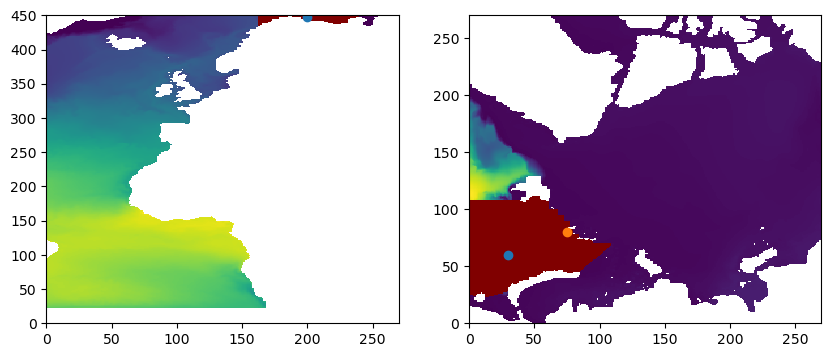

In [43]:
fig = plt.figure()

ax = plt.subplot(121)
ax.pcolormesh(faces.f1[0])
ax.pcolormesh(mymskfaces.f1[0],cmap='seismic_r')
ax.scatter(xs[0],ys[0])

ax = plt.subplot(122)
ax.pcolormesh(faces.f3[0])
ax.pcolormesh(mymskfaces.f3[0],cmap='seismic_r')
ax.scatter(xs[1],ys[1])
ax.scatter(xs[2],ys[2])

In [37]:
# do the average theta and salt profiles for these
testtheta = np.nanmean(THETA,axis=0)
testsalt = np.nanmean(SALT,axis=0)

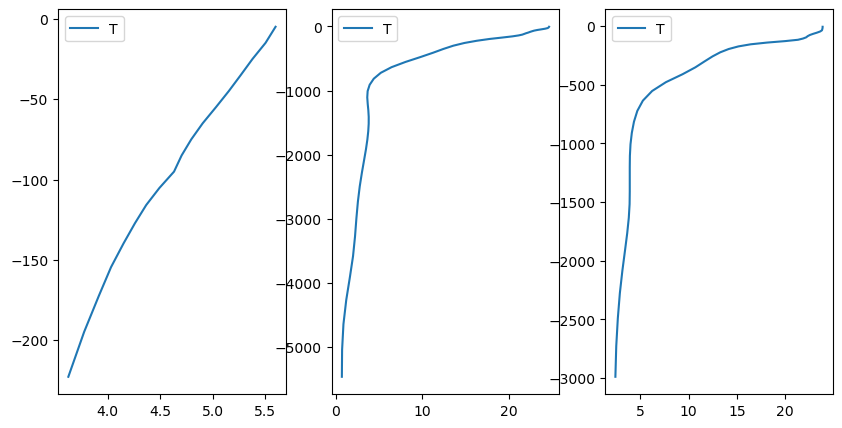

In [45]:
fig = plt.figure(figsize=(10,5))

ax = plt.subplot(131)
ax.plot(testtheta[:,ys[0],xs[0]],mygrid['RC'],label='T')
# ax.plot(testsalt[:,ys[0],xs[0]],mygrid['RC'],label='S')
ax.legend()


ax = plt.subplot(132)
ax.plot(testtheta[:,ys[1],xs[1]],mygrid['RC'],label='T')
# ax.plot(testsalt[:,ys[1],xs[1]],mygrid['RC'],label='S')
ax.legend()

ax = plt.subplot(133)
ax.plot(testtheta[:,ys[2],xs[2]],mygrid['RC'],label='T')
# ax.plot(testsalt[:,ys[2],xs[2]],mygrid['RC'],label='S')
ax.legend()

# now do time-averaging (may take some fiddling)

In [78]:
# create arrays for the three five-year periods
    # heat_content # J
    # fw_content # m
    # si_area_all # m^2

heat_content5yrs = np.full((3,ny,nx),np.nan)
fw_content5yrs = np.full((3,ny,nx),np.nan)
si_area_all5yrs = np.full((3,ny,nx),np.nan)

In [79]:
start = 0
for i in range(3):
    heat_content_avg = np.mean(heat_content[start:start+5, :, :, :], axis=0)     # average for the years
    heat_content_avg = np.mean(heat_content_avg[:, :, :], axis=0)                # average across all months
    heat_content5yrs[i] = heat_content_avg

    fw_content_avg = np.mean(fw_content[start:start+5, :, :, :], axis=0)
    fw_content_avg = np.mean(fw_content_avg[:, :, :], axis=0)
    fw_content5yrs[i] = fw_content_avg


    # for SIarea it makes more sense to do this for winter (months 0,1,2) 
    si_area_avg = np.mean(si_area_all[start:start+5, :3, :, :], axis=0)
    si_area_avg = np.mean(si_area_avg,axis=0)
    si_area_all5yrs[i] = si_area_avg
    
    start += 5

In [80]:
# try to add the lat and long values to make a prettier plot

Text(0.5, 1.0, "Heat Anomaly '13-'17")

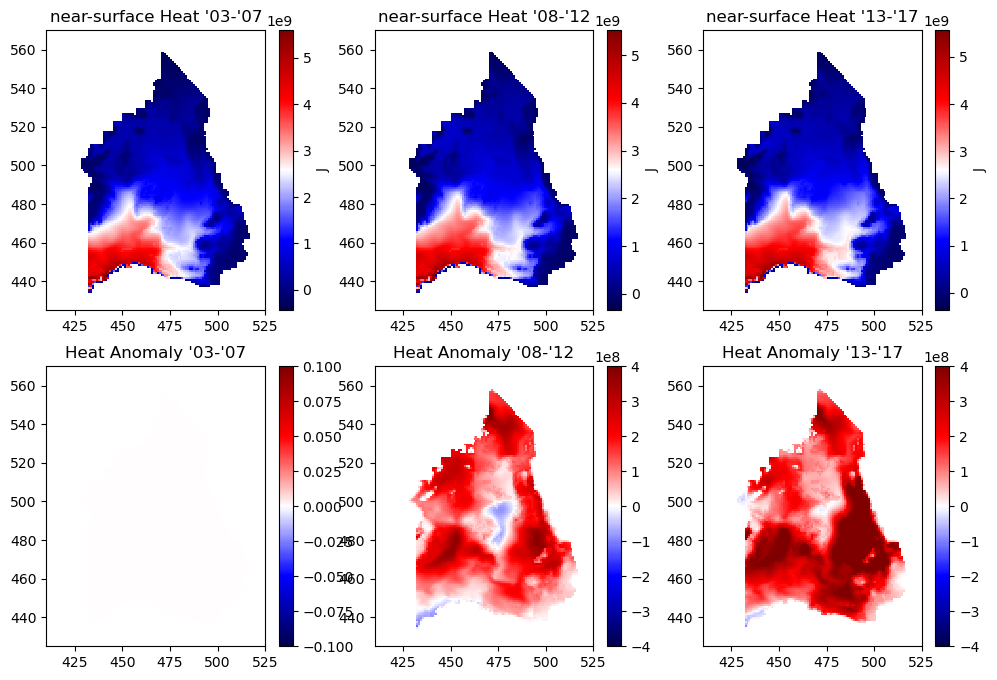

In [81]:
# start with the heat content figure
fig = plt.figure(figsize=(12,8))

# plot the local heat content changes
ax = plt.subplot(231)
data1 = get_aste_tracer(heat_content5yrs[0],nfx,nfy)[0]
data1[data1 ==0] = np.nan
cb = ax.pcolormesh(data1,cmap = 'seismic')
plt.colorbar(cb,label="J")
ax.set_xlim(410,525)
ax.set_ylim(425,570)
ax.set_title("near-surface Heat '03-'07")

ax = plt.subplot(232)
data2 = get_aste_tracer(heat_content5yrs[1],nfx,nfy)[0]
data2[data2 ==0] = np.nan
cb = ax.pcolormesh(data2,cmap = 'seismic')
plt.colorbar(cb,label="J")
ax.set_xlim(410,525)
ax.set_ylim(425,570)
ax.set_title("near-surface Heat '08-'12")

ax = plt.subplot(233)
data3 = get_aste_tracer(heat_content5yrs[2],nfx,nfy)[0]
data3[data3 ==0] = np.nan
cb = ax.pcolormesh(data3,cmap = 'seismic')
plt.colorbar(cb,label="J")
ax.set_xlim(410,525)
ax.set_ylim(425,570)
ax.set_title("near-surface Heat '13-'17")

# plot the anomalies in heat content changes
ax = plt.subplot(234)
cb = ax.pcolormesh(data1-data1,cmap = 'seismic')
plt.colorbar(cb)
ax.set_xlim(410,525)
ax.set_ylim(425,570)
ax.set_title("Heat Anomaly '03-'07")

ax = plt.subplot(235)
cb = ax.pcolormesh(data2-data1,cmap = 'seismic',vmin=-4e8,vmax=4e8)
plt.colorbar(cb)
ax.set_xlim(410,525)
ax.set_ylim(425,570)
ax.set_title("Heat Anomaly '08-'12")

ax = plt.subplot(236)
mskheat = data3-data1
cb = ax.pcolormesh(data3-data1,cmap = 'seismic',vmin=-4e8,vmax=4e8)
plt.colorbar(cb)
ax.set_xlim(410,525)
ax.set_ylim(425,570)
ax.set_title("Heat Anomaly '13-'17")

Text(0.5, 1.0, "FW Anomaly '13-'17")

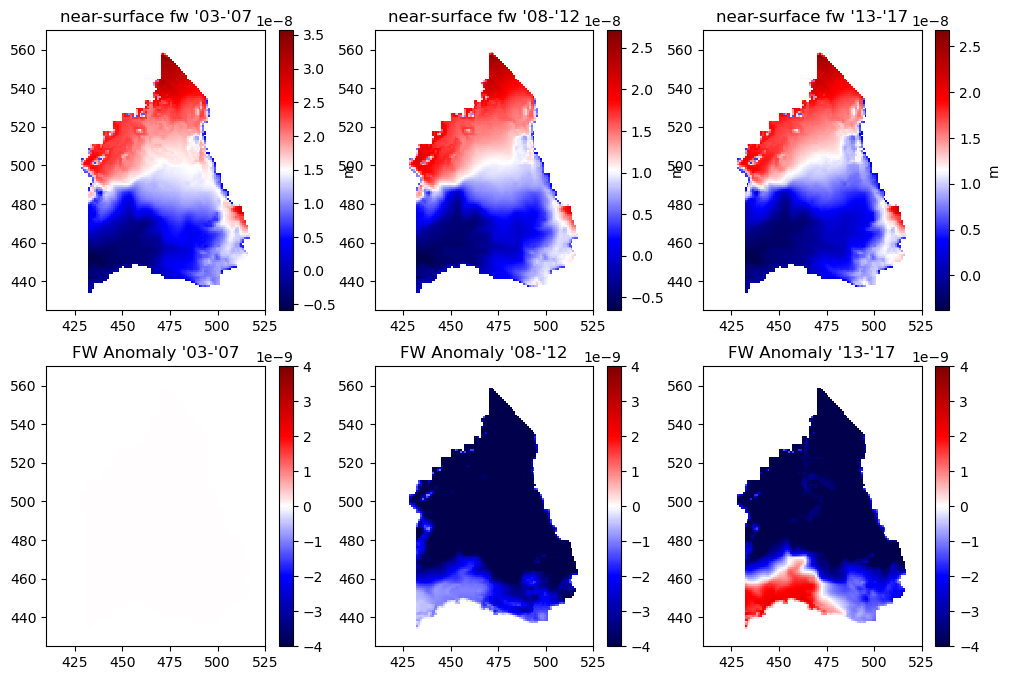

In [82]:
# start with the heat content figure
fig = plt.figure(figsize=(12,8))

# plot the local heat content changes
ax = plt.subplot(231)
data1 = get_aste_tracer(fw_content5yrs[0],nfx,nfy)[0]
data1[data1 ==0] = np.nan
cb = ax.pcolormesh(data1,cmap = 'seismic')
plt.colorbar(cb,label="m")
ax.set_xlim(410,525)
ax.set_ylim(425,570)
ax.set_title("near-surface fw '03-'07")

ax = plt.subplot(232)
data2 = get_aste_tracer(fw_content5yrs[1],nfx,nfy)[0]
data2[data2 ==0] = np.nan
cb = ax.pcolormesh(data2,cmap = 'seismic')
plt.colorbar(cb,label="m")
ax.set_xlim(410,525)
ax.set_ylim(425,570)
ax.set_title("near-surface fw '08-'12")

ax = plt.subplot(233)
data3 = get_aste_tracer(fw_content5yrs[2],nfx,nfy)[0]
data3[data3 ==0] = np.nan
cb = ax.pcolormesh(data3,cmap = 'seismic')
plt.colorbar(cb,label="m")
ax.set_xlim(410,525)
ax.set_ylim(425,570)
ax.set_title("near-surface fw '13-'17")

# plot the anomalies in heat content changes
ax = plt.subplot(234)
cb = ax.pcolormesh(data1-data1,cmap = 'seismic',vmin=-4e-9,vmax=4e-9)
plt.colorbar(cb)
ax.set_xlim(410,525)
ax.set_ylim(425,570)
ax.set_title("FW Anomaly '03-'07")

ax = plt.subplot(235)
cb = ax.pcolormesh(data2-data1,cmap = 'seismic',vmin=-4e-9,vmax=4e-9)
plt.colorbar(cb)
ax.set_xlim(410,525)
ax.set_ylim(425,570)
ax.set_title("FW Anomaly '08-'12")

ax = plt.subplot(236)
mskfw = data3-data1
cb = ax.pcolormesh(data3-data1,cmap = 'seismic',vmin=-4e-9,vmax=4e-9)
plt.colorbar(cb)
ax.set_xlim(410,525)
ax.set_ylim(425,570)
ax.set_title("FW Anomaly '13-'17")

Text(0.5, 1.0, "SIarea Anomaly '13-'17")

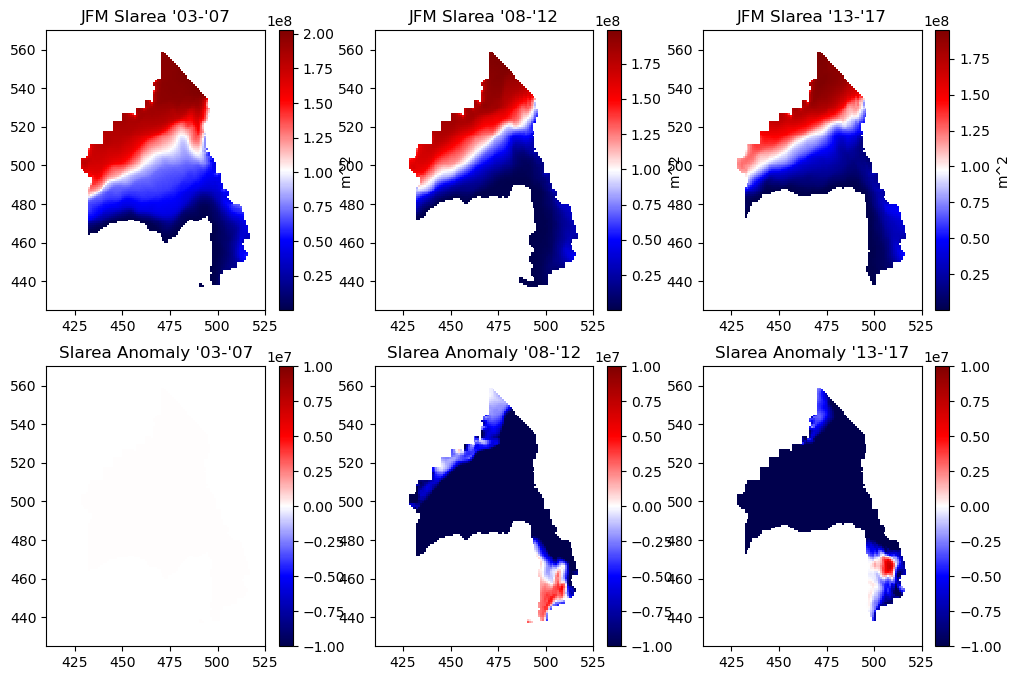

In [83]:
# also plot the sea ice and the sea ice anomaly
# start with the heat content figure
fig = plt.figure(figsize=(12,8))

# plot the local heat content changes
ax = plt.subplot(231)
data1 = get_aste_tracer(si_area_all5yrs[0],nfx,nfy)[0]
data1[data1 ==0] = np.nan
cb = ax.pcolormesh(data1,cmap = 'seismic')
plt.colorbar(cb,label="m^2")
ax.set_xlim(410,525)
ax.set_ylim(425,570)
ax.set_title("JFM SIarea '03-'07")

ax = plt.subplot(232)
data2 = get_aste_tracer(si_area_all5yrs[1],nfx,nfy)[0]
data2[data2 ==0] = np.nan
cb = ax.pcolormesh(data2,cmap = 'seismic')
plt.colorbar(cb,label="m^2")
ax.set_xlim(410,525)
ax.set_ylim(425,570)
ax.set_title("JFM SIarea '08-'12")

ax = plt.subplot(233)
data3 = get_aste_tracer(si_area_all5yrs[2],nfx,nfy)[0]
data3[data3 ==0] = np.nan
cb = ax.pcolormesh(data3,cmap = 'seismic')
plt.colorbar(cb,label="m^2")
ax.set_xlim(410,525)
ax.set_ylim(425,570)
ax.set_title("JFM SIarea '13-'17")

# plot the anomalies in heat content changes
ax = plt.subplot(234)
cb = ax.pcolormesh(data1-data1,cmap = 'seismic',vmin=-1e7,vmax=1e7)
plt.colorbar(cb)
ax.set_xlim(410,525)
ax.set_ylim(425,570)
ax.set_title("SIarea Anomaly '03-'07")

ax = plt.subplot(235)
cb = ax.pcolormesh(data2-data1,cmap = 'seismic',vmin=-1e7,vmax=1e7)
plt.colorbar(cb)
ax.set_xlim(410,525)
ax.set_ylim(425,570)
ax.set_title("SIarea Anomaly '08-'12")

ax = plt.subplot(236)
mskice = data3-data1
cb = ax.pcolormesh(data3-data1,cmap = 'seismic',vmin=-1e7,vmax=1e7)
plt.colorbar(cb)
ax.set_xlim(410,525)
ax.set_ylim(425,570)
ax.set_title("SIarea Anomaly '13-'17")

# create the mask based on the anomalies

Text(0.5, 1.0, '+heat anomaly, + FW anomaly')

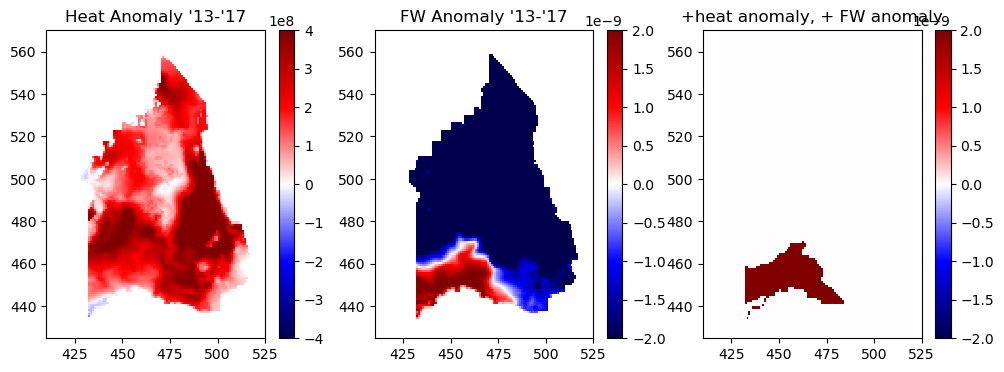

In [84]:
# plot just the anomalies from the final 5 years and a mask
test = np.zeros((900,540))
test[(mskheat > 0) & (mskfw > 0)] = 1

fig = plt.figure(figsize = (12,4))

ax = plt.subplot(131)
cb = ax.pcolormesh(mskheat,cmap = 'seismic',vmin=-4e8,vmax=4e8)
plt.colorbar(cb)
ax.set_xlim(410,525)
ax.set_ylim(425,570)
ax.set_title("Heat Anomaly '13-'17")

ax = plt.subplot(132)
cb = ax.pcolormesh(mskfw,cmap = 'seismic',vmin=-2e-9,vmax=2e-9)
plt.colorbar(cb)
ax.set_xlim(410,525)
ax.set_ylim(425,570)
ax.set_title("FW Anomaly '13-'17")

ax = plt.subplot(133)
cb = ax.pcolormesh(test,cmap = 'seismic',vmin=-2e-9,vmax=2e-9)
plt.colorbar(cb)
ax.set_xlim(410,525)
ax.set_ylim(425,570)
ax.set_title("+heat anomaly, + FW anomaly")

Text(0.5, 1.0, '+heat anomaly, -fw anomaly')

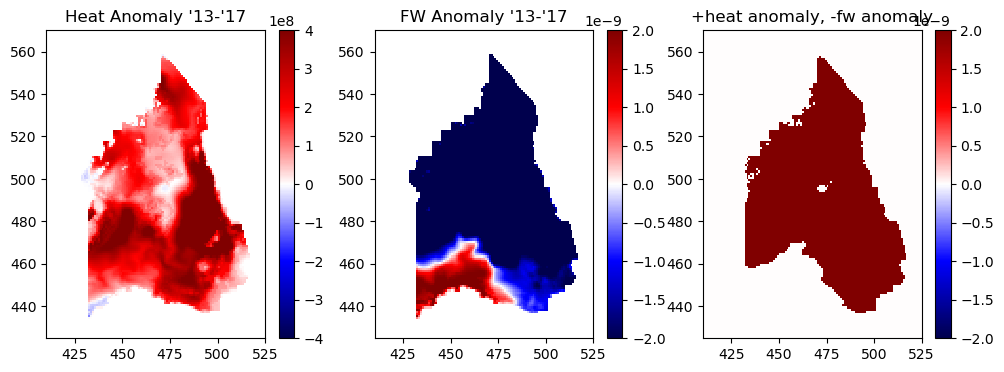

In [85]:
# plot just the anomalies from the final 5 years and a mask
test = np.zeros((900,540))
test[(mskheat > 0) & (mskfw < 0)] = 1


fig = plt.figure(figsize = (12,4))

ax = plt.subplot(131)
cb = ax.pcolormesh(mskheat,cmap = 'seismic',vmin=-4e8,vmax=4e8)
plt.colorbar(cb)
ax.set_xlim(410,525)
ax.set_ylim(425,570)
ax.set_title("Heat Anomaly '13-'17")

ax = plt.subplot(132)
cb = ax.pcolormesh(mskfw,cmap = 'seismic',vmin=-2e-9,vmax=2e-9)
plt.colorbar(cb)
ax.set_xlim(410,525)
ax.set_ylim(425,570)
ax.set_title("FW Anomaly '13-'17")

ax = plt.subplot(133)
cb = ax.pcolormesh(test,cmap = 'seismic',vmin=-2e-9,vmax=2e-9)
plt.colorbar(cb)
ax.set_xlim(410,525)
ax.set_ylim(425,570)
ax.set_title("+heat anomaly, -fw anomaly")

# save these two masks for later so we can load them in another file

In [86]:
a = heat_content5yrs[0]
b = heat_content5yrs[2]
c = b-a
d = fw_content5yrs[0]
e = fw_content5yrs[2]
f = e-d

msk1 = np.zeros((ny,nx))
msk1[(c > 0) & (f > 0)] = 1

msk2 = np.zeros((ny,nx))
msk2[(c > 0) & (f < 0)] = 1

np.savez('masks.npz', msk1=msk1, msk2=msk2)

In [8]:
# Load the .npz file
data = np.load('masks.npz')

# Access the saved masks
msk1 = data['msk1']  # mask for heating and freshening
msk2 = data['msk2']  # mask for heating and salting

# print(msk1_loaded)
# print(msk2_loaded)

# look at the average theta and salt distribution with depth for three 5-year periods

2003--2007

2008--2012

2013--2017

In [9]:
# do this by looping through the salt and heat -- we want to make an average of these as depth
theta_dist1 = np.zeros((len(allyears),12,nz))
salt_dist1 = np.zeros((len(allyears),12,nz))

# for heating and salting portion -- see if this is different
theta_dist2 = np.zeros((len(allyears),12,nz))
salt_dist2 = np.zeros((len(allyears),12,nz))

# do indexing in years for the layers
iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ##########################################################################################
    # get the theta/salt values
    # we also want salt to do the FW content
    # we want temperature and salt
    THETADR = np.full((len(tsstr),nz,ny,nx),np.nan)
    SALTDR = np.full((len(tsstr),nz,ny,nx),np.nan)
    
    for i in range(len(tsstr)):
    
        # read the fldList
        file_name = 'budg3d_snap_set2'
        meta_budg3d_snap_set2 = parsemeta(dirIn + file_name + "." + tsstr[i] + ".meta")
        fldlist = np.array(meta_budg3d_snap_set2["fldList"])
        varnames = np.array(["THETADR","SALTDR"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        THETADRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[0])  # degC.m
        SALTDRi,its,meta = rdmds(os.path.join(dirIn, file_name),read,returnmeta=True,rec=recs[1])  # degC.m
    
        THETADR[i,:,:,:] = np.reshape(THETADRi,(nz,ny,nx))
        SALTDR[i,:,:,:] = np.reshape(SALTDRi,(nz,ny,nx))

    for i in range(len(datetimes)):
        # for calculating heat content:
            # weighted theta * rcp = J/m^2 which is the depth-weighted heat content of a cell
            # integrate over all values within the depth interval of choice
        # do the depth meaning for theta
        thisTHETA = THETADR[i]/DRF3d/mygrid['hFacC'] * msk1[np.newaxis,:,:]    # degC
        thisTHETA[thisTHETA == 0] = np.nan   # this was messing up averaging without this precaution
        theta_dist1[iy,i,:] = np.nanmean(thisTHETA, axis = (1,2))  # depth average of shape nz
        thisTHETA = THETADR[i]/DRF3d/mygrid['hFacC'] * msk2[np.newaxis,:,:]    # degC
        thisTHETA[thisTHETA == 0] = np.nan
        theta_dist2[iy,i,:] = np.nanmean(thisTHETA, axis = (1,2))

        # do the depth averaging for freshwater
        thisSALT = SALTDR[i]/DRF3d/mygrid['hFacC'] * msk1[np.newaxis,:,:]    # PSU
        thisSALT[thisSALT == 0] = np.nan
        salt_dist1[iy,i,:] = np.nanmean(thisSALT, axis = (1,2))  # depth average of shape nz
        thisSALT = SALTDR[i]/DRF3d/mygrid['hFacC'] * msk2[np.newaxis,:,:]    # PSU
        thisSALT[thisSALT == 0] = np.nan
        salt_dist2[iy,i,:] = np.nanmean(thisSALT, axis = (1,2))

    iy += 1

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


# do the averaging for the three 5-year time periods and plot these with depth

In [10]:
figpath = '/home/mmurakami/crios_backups/ASTE_270/BarentsS_paper/sample_figs/'

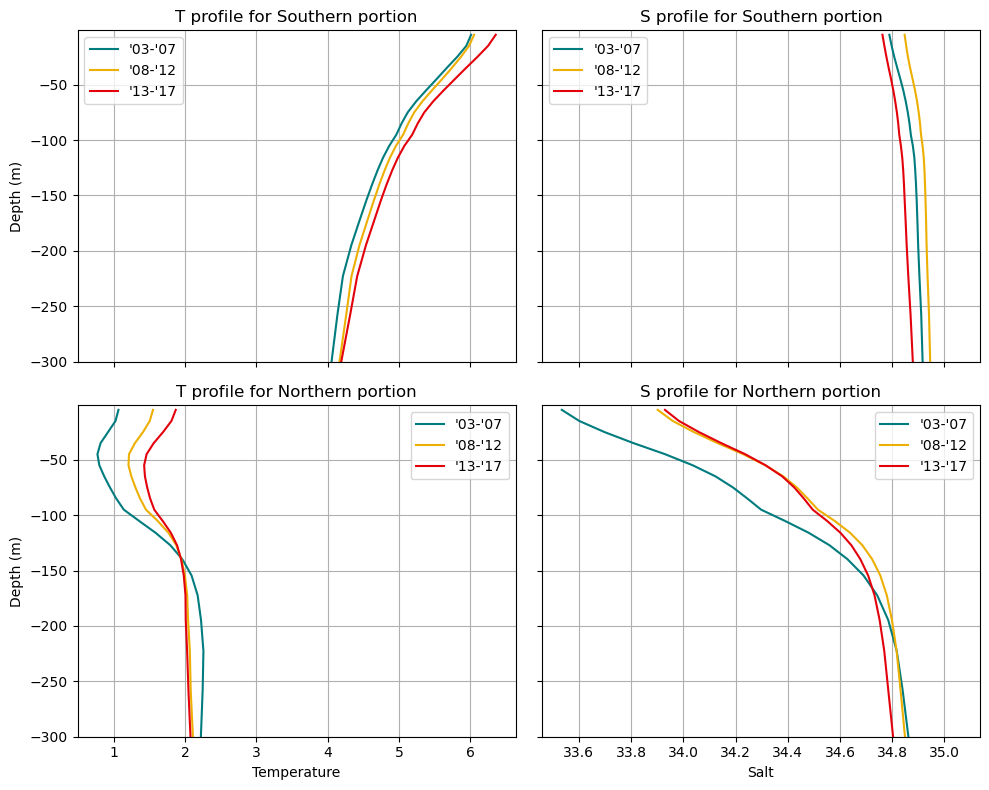

In [11]:
# colors
c1 = '#007c7e'
c2 = '#edaf02'
c3 = '#e3010c'

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex='col', sharey=True)

# First plot: Temperature profile for Southern portion
axes[0, 0].plot(np.nanmean(theta_dist1[:5], axis=(0, 1)), mygrid['RC'], label="'03-'07",color=c1)
axes[0, 0].plot(np.nanmean(theta_dist1[5:10], axis=(0, 1)), mygrid['RC'], label="'08-'12",color=c2)
axes[0, 0].plot(np.nanmean(theta_dist1[10:], axis=(0, 1)), mygrid['RC'], label="'13-'17",color=c3)
axes[0, 0].set_ylim(-300, -1)
axes[0, 0].set_title("T profile for Southern portion")
axes[0, 0].legend()
axes[0, 0].grid()
axes[0, 0].set_ylabel("Depth (m)")  # Y-axis label

# Second plot: Salinity profile for Southern portion
axes[0, 1].plot(np.nanmean(salt_dist1[:5], axis=(0, 1)), mygrid['RC'], label="'03-'07",color=c1)
axes[0, 1].plot(np.nanmean(salt_dist1[5:10], axis=(0, 1)), mygrid['RC'], label="'08-'12",color=c2)
axes[0, 1].plot(np.nanmean(salt_dist1[10:], axis=(0, 1)), mygrid['RC'], label="'13-'17",color=c3)
axes[0, 1].set_ylim(-300, -1)
axes[0, 1].set_title("S profile for Southern portion")
axes[0, 1].legend()
axes[0, 1].grid()

# Third plot: Temperature profile for Northern portion
axes[1, 0].plot(np.nanmean(theta_dist2[:5], axis=(0, 1)), mygrid['RC'], label="'03-'07",color=c1)
axes[1, 0].plot(np.nanmean(theta_dist2[5:10], axis=(0, 1)), mygrid['RC'], label="'08-'12",color=c2)
axes[1, 0].plot(np.nanmean(theta_dist2[10:], axis=(0, 1)), mygrid['RC'], label="'13-'17",color=c3)
axes[1, 0].set_ylim(-300, -1)
axes[1, 0].set_title("T profile for Northern portion")
axes[1, 0].legend()
axes[1, 0].grid()
axes[1, 0].set_xlabel("Temperature")  # X-axis label
axes[1, 0].set_ylabel("Depth (m)")  # Y-axis label

# Fourth plot: Salinity profile for Northern portion
axes[1, 1].plot(np.nanmean(salt_dist2[:5], axis=(0, 1)), mygrid['RC'], label="'03-'07",color=c1)
axes[1, 1].plot(np.nanmean(salt_dist2[5:10], axis=(0, 1)), mygrid['RC'], label="'08-'12",color=c2)
axes[1, 1].plot(np.nanmean(salt_dist2[10:], axis=(0, 1)), mygrid['RC'], label="'13-'17",color=c3)
axes[1, 1].set_ylim(-300, -1)
axes[1, 1].set_title("S profile for Northern portion")
axes[1, 1].legend()
axes[1, 1].grid()
axes[1, 1].set_xlabel("Salt")  # X-axis label

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig(figpath + "profiles.png", dpi=300)

# print("Profiles saved to 'profiles.png'")

# find a prettier way to plot the two masks here

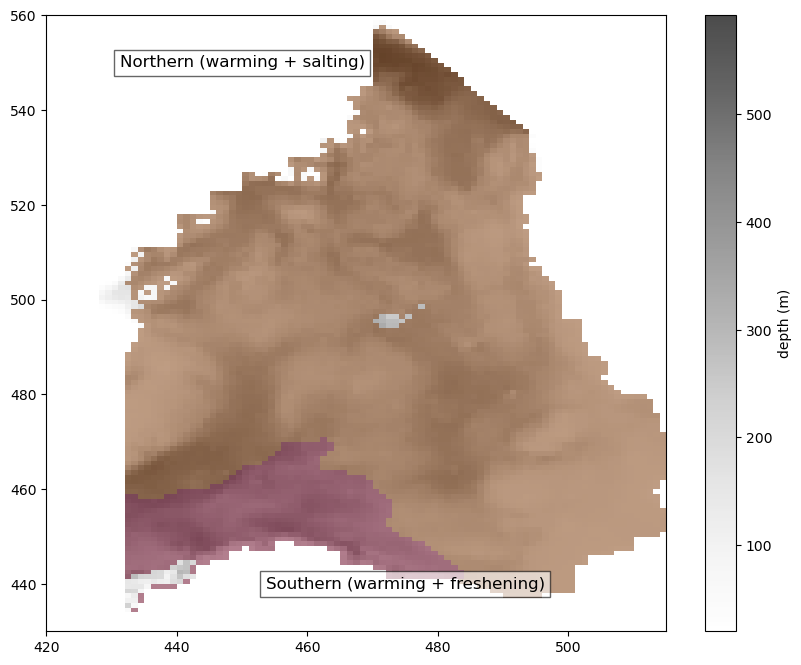

In [202]:
fig = plt.figure(figsize=(10, 8))

# Main plot with Depth data
ax = plt.subplot(111)
cb = ax.pcolormesh(get_aste_tracer(mygrid['Depth'] * mymsk, nfx, nfy)[0], 
                   alpha=0.7, cmap="Greys")
plt.colorbar(cb,label="depth (m)")

# Set axis limits
ax.set_xlim(420, 515)
ax.set_ylim(430, 560)

# First colormap: Southern portion
test1 = msk1.copy()
test1[test1 == 0] = np.nan  # Replace 0 with NaN for transparency
ax.pcolormesh(get_aste_tracer(test1, nfx, nfy)[0], alpha=0.5, cmap="RdBu")

# Add label for the first colormap
ax.text(450, 550, "Northern (warming + salting)", color='black', fontsize=12, 
        ha='center', va='center', bbox=dict(facecolor='white', alpha=0.6))

# Second colormap: Northern portion
test2 = msk2.copy()
test2[test2 == 0] = np.nan  # Replace 0 with NaN for transparency
ax.pcolormesh(get_aste_tracer(test2, nfx, nfy)[0], alpha=0.5, cmap="PuOr")

# Add label for the second colormap
ax.text(475, 440, "Southern (warming + freshening)", color='black', fontsize=12, 
        ha='center', va='center', bbox=dict(facecolor='white', alpha=0.6))

# Show the plot
plt.savefig(figpath + "masks.png", dpi=300)

# also try to plot the layer thickness over time (1d)

In [13]:
mygrid['RF']

array([    0.  ,   -10.  ,   -20.  ,   -30.  ,   -40.  ,   -50.  ,
         -60.  ,   -70.  ,   -80.01,   -90.04,  -100.15,  -110.47,
        -121.27,  -133.03,  -146.45,  -162.49,  -182.31,  -207.16,
        -238.26,  -276.68,  -323.18,  -378.18,  -441.68,  -513.26,
        -592.16,  -677.31,  -767.49,  -861.45,  -958.03, -1056.28,
       -1155.53, -1255.54, -1356.87, -1461.43, -1572.76, -1695.59,
       -1834.68, -1993.62, -2174.45, -2378.  , -2604.5 , -2854.  ,
       -3126.5 , -3422.  , -3740.5 , -4082.  , -4446.5 , -4834.  ,
       -5244.5 , -5678.  , -6134.5 ])

In [ ]:
# create a mask for the Arctic Water fo